# Assignment

<h1> Amazon Apparel Recommendations </h1>



###  Overview of the data

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
from PIL import Image
from IPython.display import display,  SVG, Math, YouTubeVideo

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [ ]:
# we have give a json file which consists of all information about
# the products
# loading the data using pandas' read_json file.
data = pd.read_json('tops_fashion.json')


In [ ]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

### Terminology:
What is a dataset? <br>
Rows and columns <br>
Data-point <br>
Feature/variable <br>







In [ ]:
# each product/item has 19 features in the raw dataset.
data.columns # prints column-names or feature-names.

Of these 19 features, we will be using only 6 features in this workshop.
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

In [ ]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [ ]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() # prints the top rows in the table.

# Assignment

In [3]:
# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

#### IDF_W2V title

In [4]:
# IDF_W2V of title
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

#if you do NOT have RAM >= 12GB, use the code below.
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)


In [5]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])


vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and (word in  idf_title_vectorizer.vocabulary_):
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

# generating IDF W2v
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)


#### Brand + Color feature + type feature

In [6]:
#Brand +Color feature
data['brand'].fillna(value="Not given", inplace=True )
# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

#### Image Feature

In [7]:
# image feature
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

## Modeling (Idf_w2v Title + Extra features + Image features)

In [8]:
# utility functions
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, model):

    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].iloc[doc_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].iloc[doc_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()
    

#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
    
def get_word_vec(sentence, doc_id, m_name):

    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    return  np.array(vec)


def get_distance(vec1, vec2):

    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    return np.array(final_dist)



In [9]:
# re indexing of bottleneck_features_train
bottleneck_features_train_reindexing = np.zeros(bottleneck_features_train.shape)
for idx, i in enumerate(df_asins):    
    bottleneck_features_train_reindexing[idx]=bottleneck_features_train[asins.index(i)]
    
bottleneck_features_train_reindexing.shape

(16042, 25088)

In [18]:

def idf_w2vtitle__brand_color_type_image(doc_id, w1, w2, w3, num_results):

    idf_w2v_dist  = pairwise_distances(w2v_title_weight , w2v_title_weight[doc_id].reshape(1,-1) )
    ex_feat_dist = pairwise_distances( extra_features, extra_features[doc_id] )
    image_feature = pairwise_distances( bottleneck_features_train_reindexing , bottleneck_features_train_reindexing[doc_id].reshape(1,-1))
    
    pairwise_dist   = ((w1 * idf_w2v_dist) +  (w2 * ex_feat_dist) + (w3 * image_feature))/float(w1 + w2 + w3)
       
    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    return (w1,w2,w3), pdists.sum()

#************************************************************************************************************************************************

# choosing optimal weights of features on the basis of minimum eculidean distance
weight=[]
dist=[]
w1=[20,50,75,100,150,200]
w2=[20,50,75,100,150,200]
w3=[20,50,75,100,150,200]
for wi in w1:
    for wj in w2:
        for wk in w3:
            w,d=idf_w2vtitle__brand_color_type_image(12566, wi, wj, wk, 15)
            weight.append(w)
            dist.append(d)
        

In [19]:
optimum_weights=weight[np.argmin(dist)]
print(f" optimum weight of titles: {optimum_weights[0]}\n optimum weight of extra features: {optimum_weights[1]}\n optimum weight of image_features: {optimum_weights[2]}")

 optimum weight of titles: 200
 optimum weight of extra features: 200
 optimum weight of image_features: 20


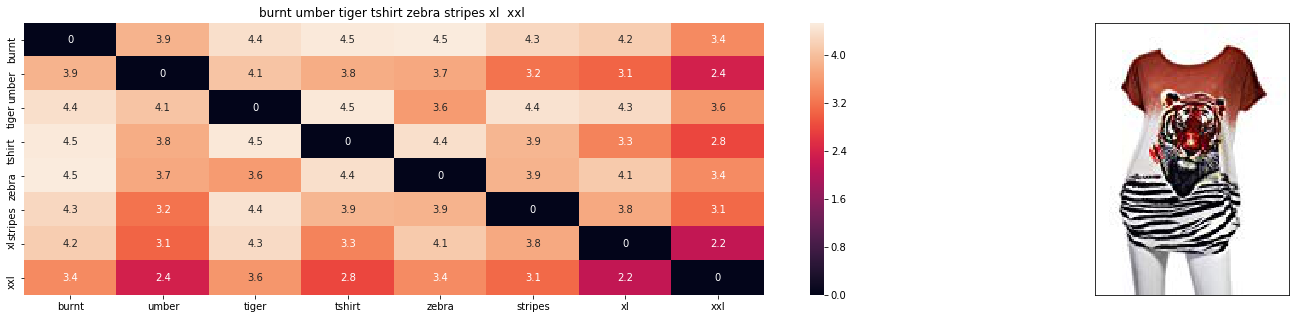

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input feature: 0.00032902879140286217
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


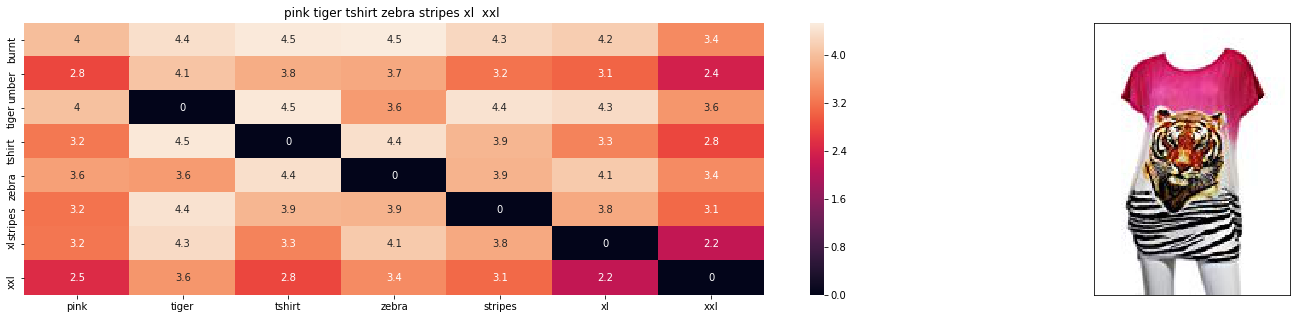

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input feature: 2.38496375600562
Amazon Url: www.amzon.com/dp/B00JXQASS6


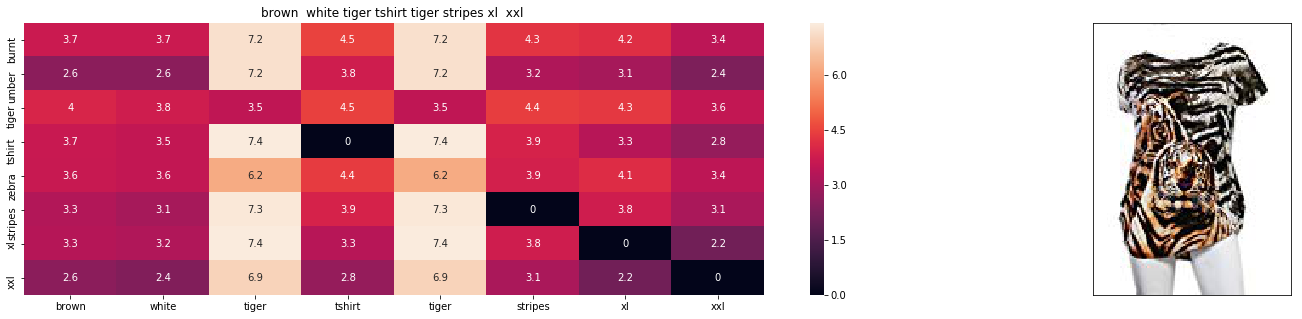

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input feature: 2.7170361261967972
Amazon Url: www.amzon.com/dp/B00JXQCWTO


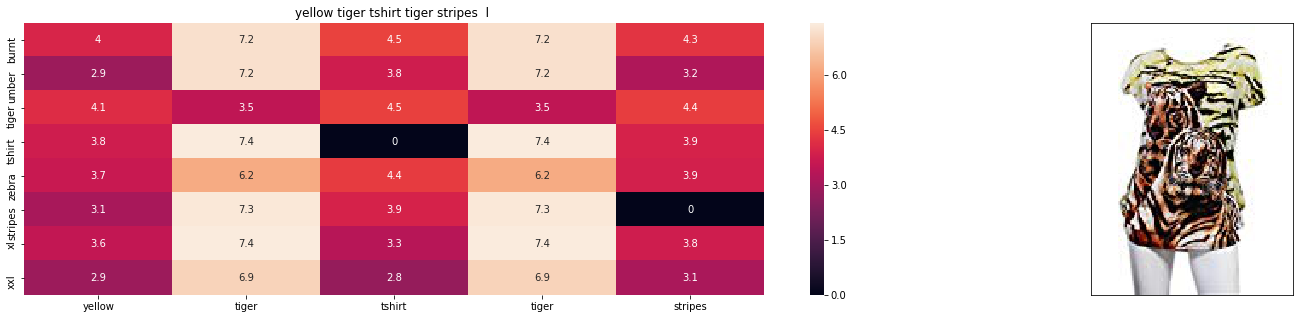

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input feature: 3.5204009915330077
Amazon Url: www.amzon.com/dp/B00JXQCUIC


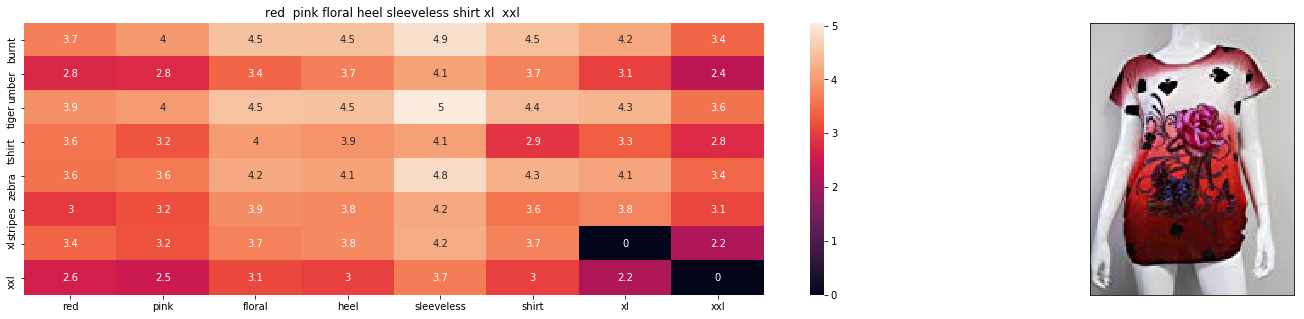

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input feature: 3.593773847313777
Amazon Url: www.amzon.com/dp/B00JV63QQE


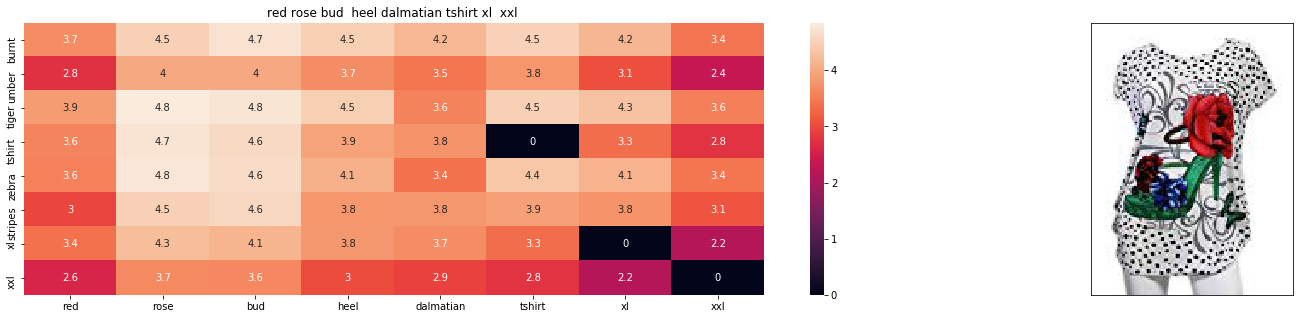

Product Title:  red rose bud  heel dalmatian tshirt xl  xxl 
Euclidean Distance from input feature: 3.6521904906769755
Amazon Url: www.amzon.com/dp/B00JXQABB0


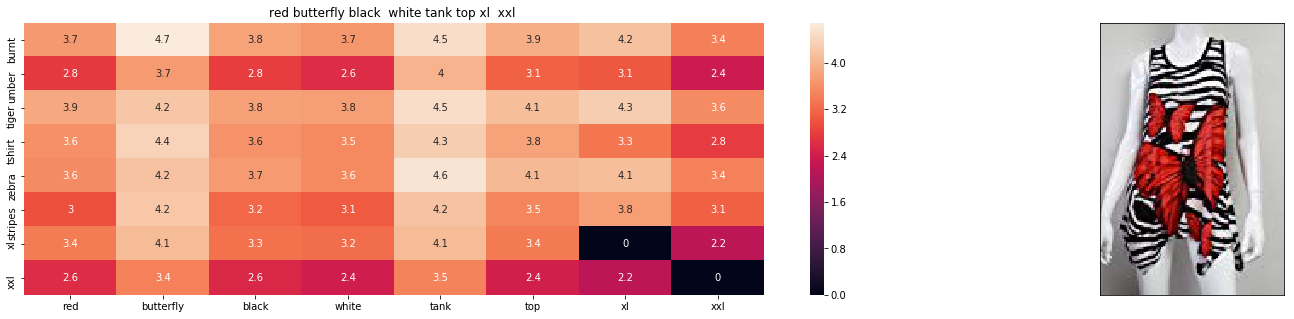

Product Title:  red butterfly black  white tank top xl  xxl 
Euclidean Distance from input feature: 3.669551155722313
Amazon Url: www.amzon.com/dp/B00JV63CW2


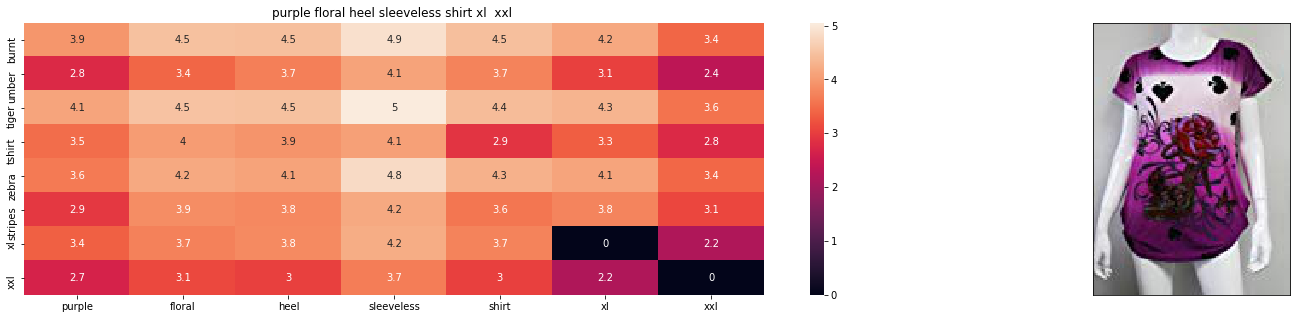

Product Title:  purple floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input feature: 3.6773345382278184
Amazon Url: www.amzon.com/dp/B00JV63VC8


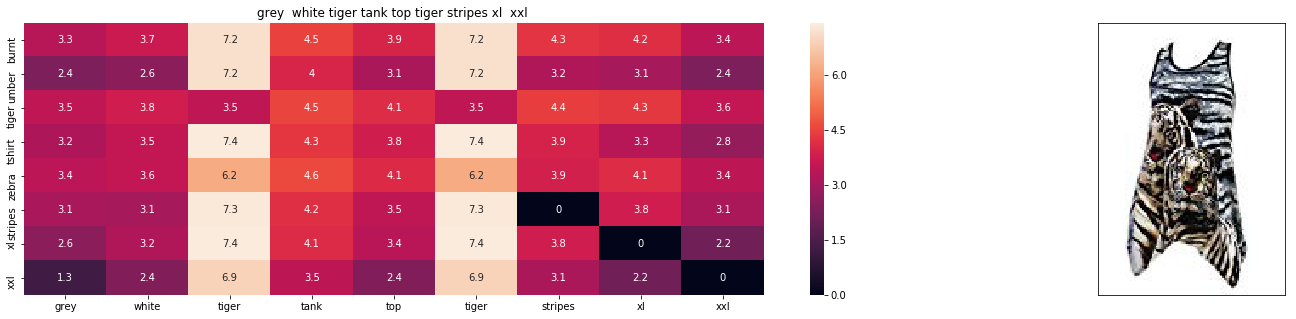

Product Title:  grey  white tiger tank top tiger stripes xl  xxl 
Euclidean Distance from input feature: 3.6983610019811475
Amazon Url: www.amzon.com/dp/B00JXQAFZ2


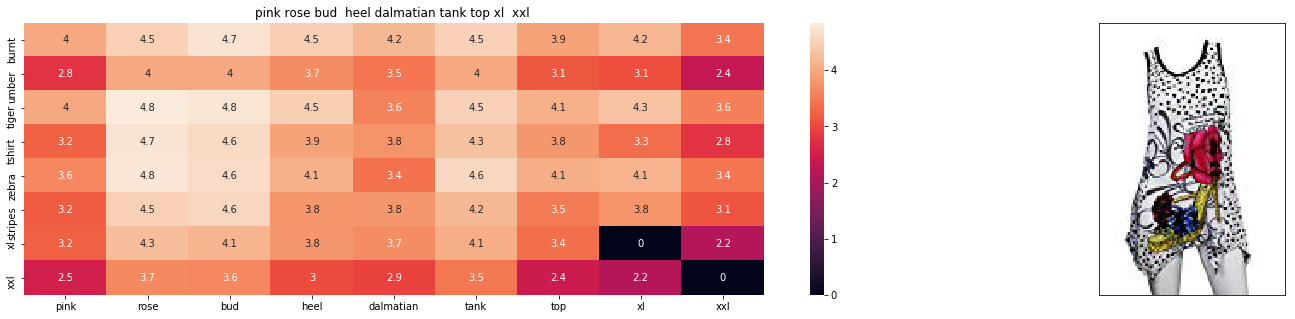

Product Title:  pink rose bud  heel dalmatian tank top xl  xxl 
Euclidean Distance from input feature: 3.70019749148232
Amazon Url: www.amzon.com/dp/B00JXQAX2C


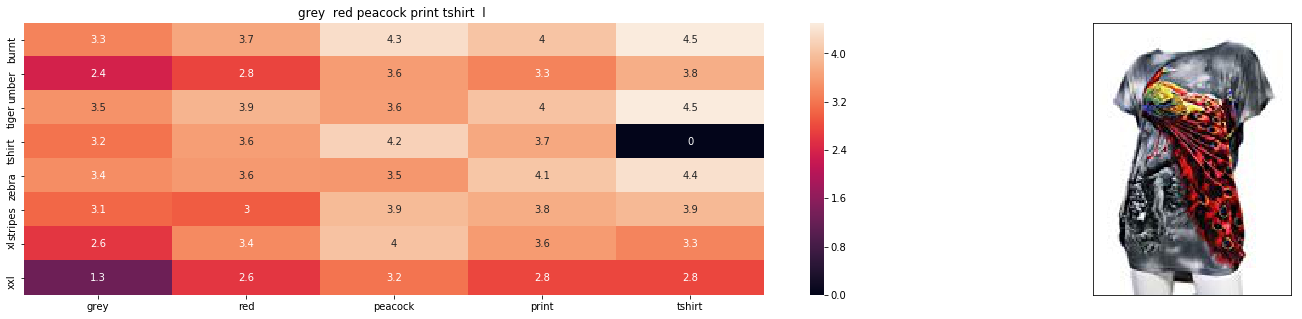

Product Title:  grey  red peacock print tshirt  l 
Euclidean Distance from input feature: 3.700996163262909
Amazon Url: www.amzon.com/dp/B00JXQCFRS


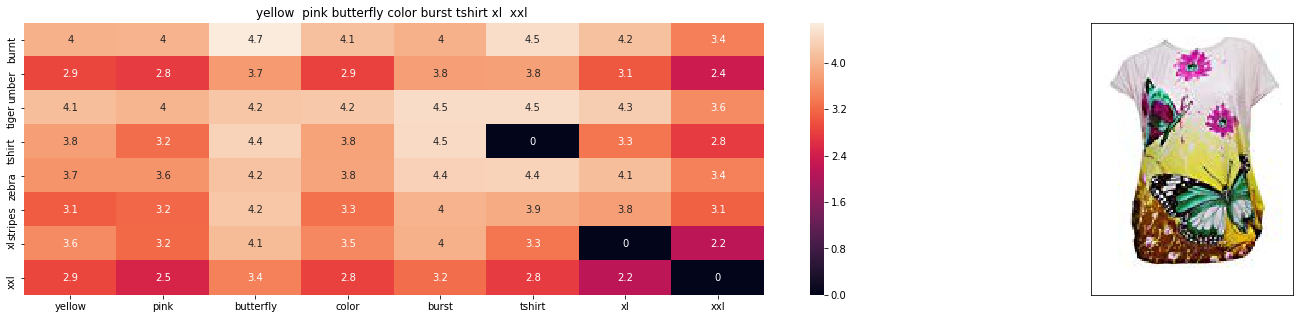

Product Title:  yellow  pink butterfly color burst tshirt xl  xxl 
Euclidean Distance from input feature: 3.749896719797049
Amazon Url: www.amzon.com/dp/B00JXQBBMI


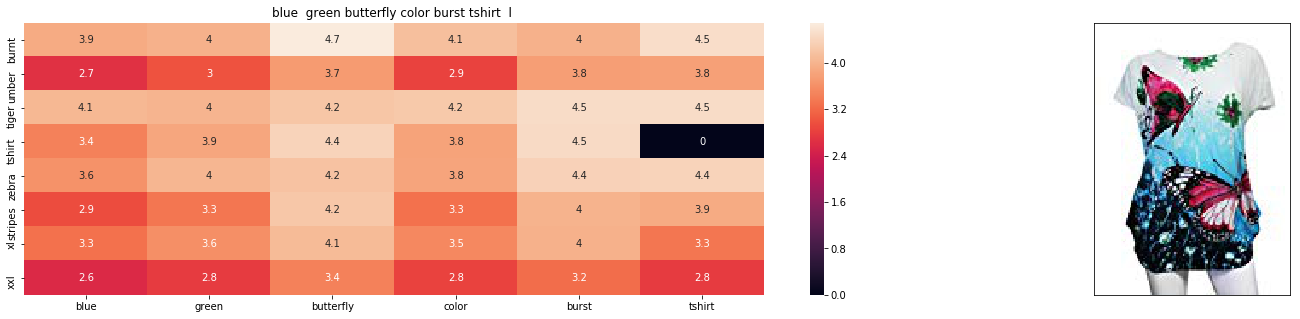

Product Title:  blue  green butterfly color burst tshirt  l 
Euclidean Distance from input feature: 3.798091798000961
Amazon Url: www.amzon.com/dp/B00JXQC0C8


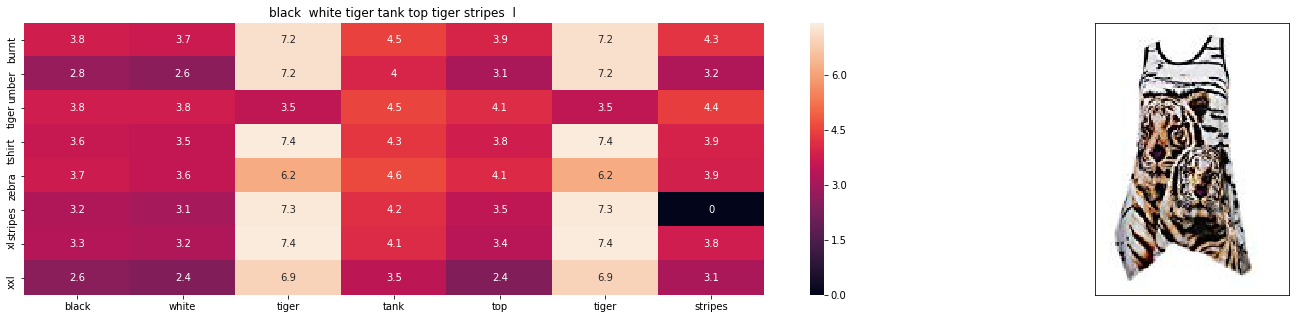

Product Title:  black  white tiger tank top tiger stripes  l 
Euclidean Distance from input feature: 3.8259186009190174
Amazon Url: www.amzon.com/dp/B00JXQAO94


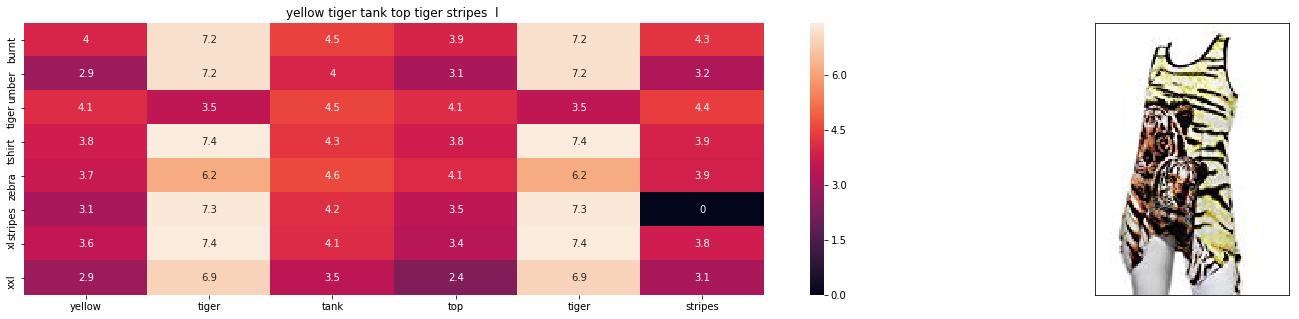

Product Title:  yellow tiger tank top tiger stripes  l 
Euclidean Distance from input feature: 3.884656628487909
Amazon Url: www.amzon.com/dp/B00JXQAUWA


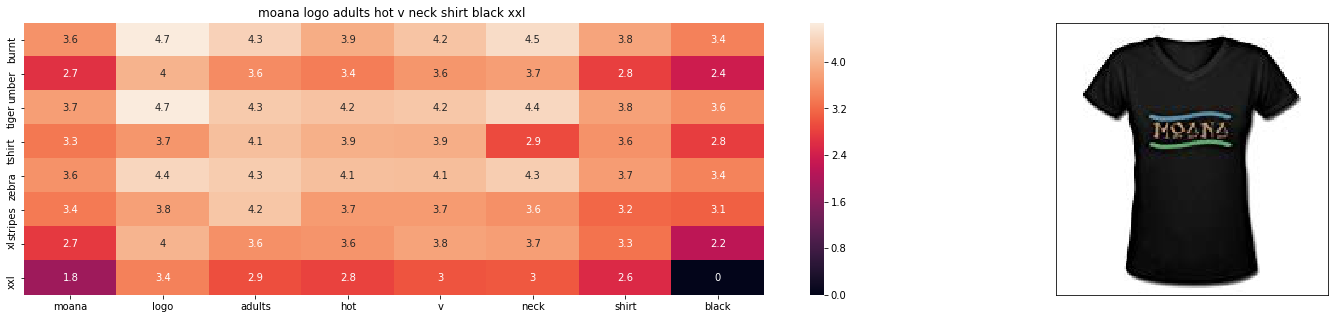

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input feature: 4.103921649817908
Amazon Url: www.amzon.com/dp/B01LX6H43D


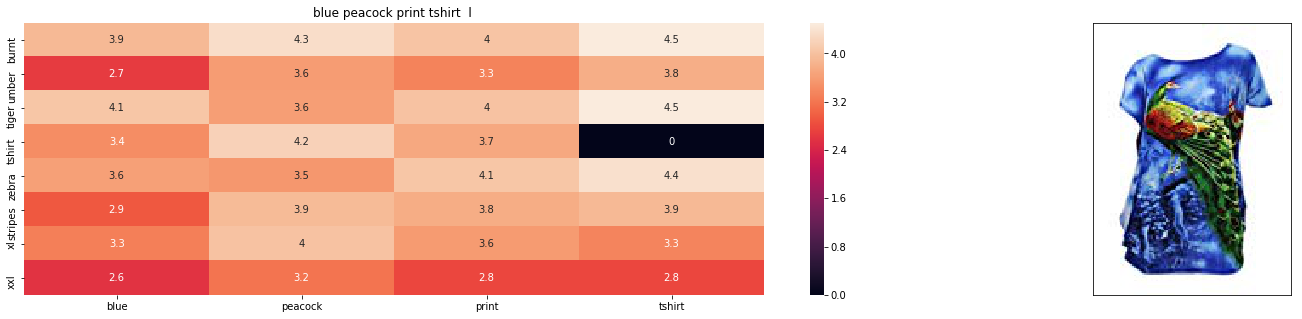

Product Title:  blue peacock print tshirt  l 
Euclidean Distance from input feature: 4.121138356889411
Amazon Url: www.amzon.com/dp/B00JXQC8L6


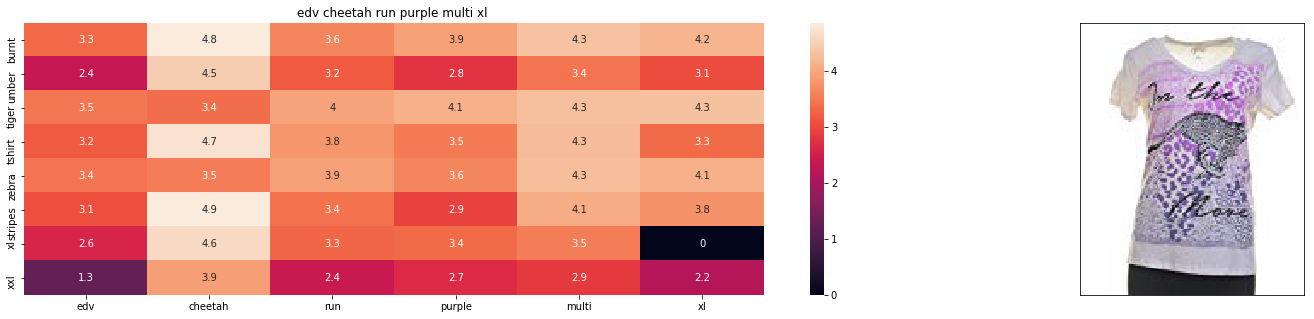

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input feature: 4.132707641663055
Amazon Url: www.amzon.com/dp/B01CUPYBM0


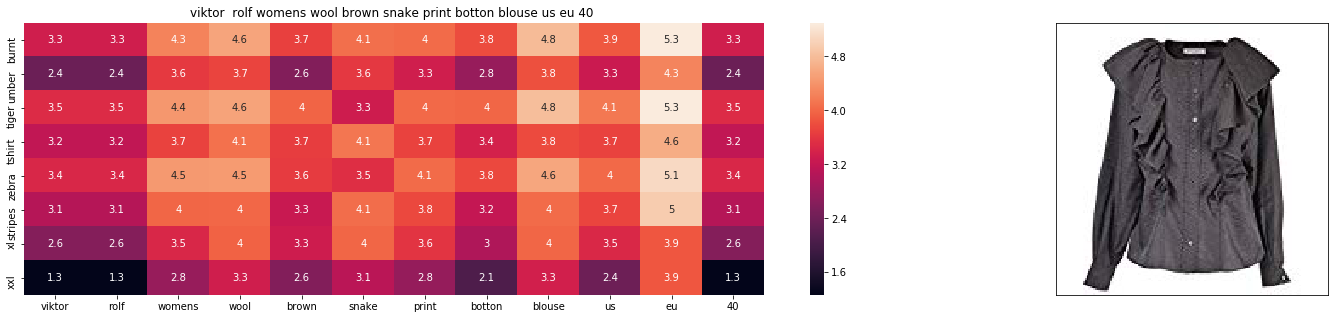

Product Title:  viktor  rolf womens wool brown snake print botton blouse us eu 40 
Euclidean Distance from input feature: 4.151090127658489
Amazon Url: www.amzon.com/dp/B00LEHNVZ4


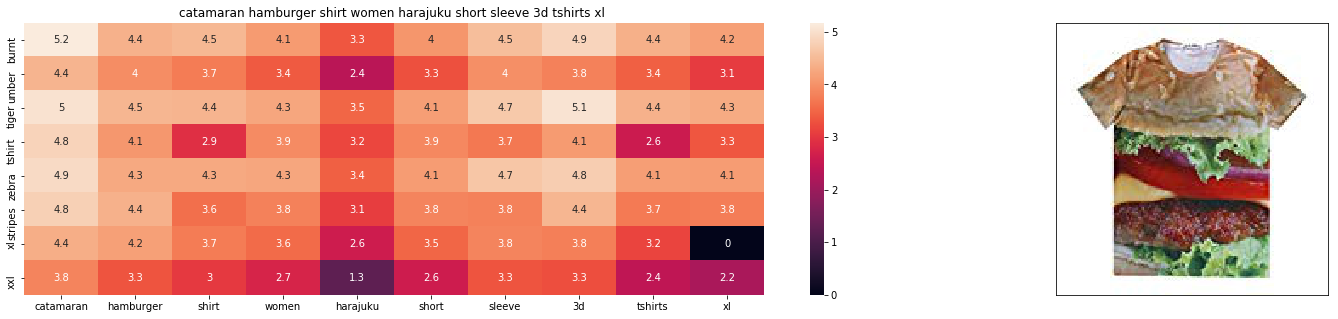

Product Title:  catamaran hamburger shirt women harajuku short sleeve 3d tshirts xl 
Euclidean Distance from input feature: 4.15282457303717
Amazon Url: www.amzon.com/dp/B01CR325BE


In [20]:
# Using optmum weights

def idf_w2vtitle__brand_color_type_image(doc_id, w1, w2, w3, num_results):

    idf_w2v_dist  = pairwise_distances(w2v_title_weight , w2v_title_weight[doc_id].reshape(1,-1) )
    ex_feat_dist = pairwise_distances( extra_features, extra_features[doc_id] )
    image_feature = pairwise_distances( bottleneck_features_train_reindexing , bottleneck_features_train_reindexing[doc_id].reshape(1,-1))
    
    pairwise_dist   = ((w1 * idf_w2v_dist) +  (w2 * ex_feat_dist) + (w3 * image_feature))/float(w1 + w2 + w3)
       
    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(len(indices)):

        heat_map_w2v_brand(data['title'].iloc[indices[0]], data['title'].iloc[indices[i]], data['medium_image_url'].iloc[indices[i]],
                               indices[0],indices[i],
                               'weighted')
        print('Product Title: ', data['title'].iloc[indices[i]])
        print('Euclidean Distance from input feature:', pdists[i])
        print('Amazon Url: www.amzon.com/dp/'+ data["asin"].iloc[indices[i]])

idf_w2vtitle__brand_color_type_image(12566,200,200, 20, 20)
        

# Conclusion

1. Combining Title features and extra features and image feature all together is definately giving better result.

2. Optimal weights I have got :

     optimum weight of titles: 200  
     
     optimum weight of extra features: 200    
     
     optimum weight of image_features: 20